In [39]:
import os
import sys

import openpyxl
import random
random.seed(42)

import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("../../util"))
from data_utils import *
from plot_utils import *


In [41]:
filename = "../../data/BicyclesRelocationData.xlsx"
wb = openpyxl.load_workbook(filename, data_only=True)


cat_sheet = wb["Categories"]
categories = [cell.value for cell in next(cat_sheet.iter_rows(min_row=1, max_row=1))]
row_surplus = next(cat_sheet.iter_rows(min_row=2, max_row=2))
row_space   = next(cat_sheet.iter_rows(min_row=3, max_row=3))

s = {cat: int(row_surplus[i].value) for i, cat in enumerate(categories)}
c = {cat: float(row_space[i].value) for i, cat in enumerate(categories)}


destinations = []
p = {}

for sheet_name in wb.sheetnames:
    if sheet_name.startswith("ExpectedProfitsArea"):
        ws = wb[sheet_name]
        dest_num = sheet_name[len("ExpectedProfitsArea"):]
        area = "Area" + dest_num
        if area not in destinations:
            destinations.append(area)
        header = [cell.value for cell in next(ws.iter_rows(min_row=1, max_row=1))]
        rows = list(ws.iter_rows(min_row=2, values_only=True))
        for i, cat in enumerate(header):
            profits = [row[i] for row in rows if row[i] is not None]
            p[(cat, area)] = profits

In [42]:
gene_order  = [(i, j) for i in categories for j in destinations]
gene_bounds = {(i, j): (0, s[i]) for (i, j) in gene_order}

def compute_total_profit(i, j, allocation):
    """Soma os primeiros N valores da lista de lucros esperados."""
    profits = p.get((i, j), [])
    return sum(profits[:allocation])  

def evaluate(individual):
    """
    Avalia um indivíduo computando o lucro total sem acumulação errada de valores.
    """
    sol = {}
    idx = 0
    for key in gene_order:
        sol[key] = individual[idx]
        idx += 1

    profit = 0
    penalty = 0

    for (i, j) in gene_order:
        allocation = sol[(i, j)]
        profit += compute_total_profit(i, j, allocation)

    for i in categories:
        total_alloc = sum(sol[(i, j)] for j in destinations)
        if total_alloc > s[i]:
            penalty += (total_alloc - s[i]) * 1000  # penalty

    return profit - penalty

In [43]:
# Create initial solution and neiborhood

def create_initial_solution():
    """
    Generate a random initial solution 
    """
    solution = []
    for key in gene_order:
        lb, ub = gene_bounds[key]
        solution.append(random.randint(lb, ub))

    return solution

def neighborhood1(solution):
    """
    Neighborhood 1: Modify one randomly chosen gene by adding or subtracting 1.
    The change is limited by the gene bounds.
    """
    neighbor = solution.copy()
    idx = random.randrange(len(solution))
    lb, ub = list(gene_bounds.values())[idx]

    delta = random.choice([-1, 1])
    new_val = neighbor[idx] + delta
    new_val = max(lb, min(ub, new_val))
    neighbor[idx] = new_val

    return neighbor

def neighborhood2(solution):
    """
    Neighborhood 2: Modify two randomly chosen genes by adding or subtracting 1.
    """
    neighbor = solution.copy()
    indices = random.sample(range(len(solution)), 2)
    for idx in indices:
        lb, ub = list(gene_bounds.values())[idx]
        delta = random.choice([-1, 1])
        new_val = neighbor[idx] + delta
        new_val = max(lb, min(ub, new_val))
        neighbor[idx] = new_val
    return neighbor

def neighborhood3(solution):

    """
    Neighborhood 3: For a randomly chosen gene, assign a new random value within its bounds.
    """
    neighbor = solution.copy()
    idx = random.randrange(len(solution))
    lb, ub = list(gene_bounds.values())[idx]
    neighbor[idx] = random.randint(lb, ub)

    return neighbor

def neighborhood4(solution):
    """
    Neighborhood 4: For a randomly chosen gene, perturb its value by a random integer within a range.
    The range is set to be up to half of the gene's allowed range.
    """
    neighbor = solution.copy()
    idx = random.randrange(len(solution))
    lb, ub = list(gene_bounds.values())[idx]
    range_val = ub - lb

    if range_val > 0:
        delta = random.randint(1, max(1, range_val // 2))
    else:
        delta = 0
    change = random.randint(-delta, delta)
    new_val = neighbor[idx] + change
    new_val = max(lb, min(ub, new_val))
    neighbor[idx] = new_val

    return neighbor

# Neigborhoods
neighborhoods = [neighborhood1, neighborhood2, neighborhood3, neighborhood4]

In [44]:
def VNS(max_iterations=5000, max_no_improve=1000, local_search_it = 20):

    """
    The VNS algorithm starts with an initial solution and iteratively explores 
    larger neighborhoods until a better solution is found or a stopping condition is met.

    Returns:
        [type]: [description]
    """

    current_solution = create_initial_solution()
    current_fitness  = evaluate(current_solution)
    best_solution    = current_solution[:]
    best_fitness     = current_fitness

    fitness_history = [best_fitness]
    iter_since_last_improve = 0
    iteration = 0

    while iteration < max_iterations and iter_since_last_improve < max_no_improve:
        k = 0

        while k < len(neighborhoods):
            
            new_solution = neighborhoods[k](current_solution)
            new_fitness = evaluate(new_solution)
            
            local_solution = new_solution[:]
            local_fitness = new_fitness

            for _ in range(local_search_it): 
                candidate = neighborhood1(local_solution)
                candidate_fitness = evaluate(candidate)
                if candidate_fitness > local_fitness:
                    local_solution = candidate[:]
                    local_fitness = candidate_fitness
            
            if local_fitness > current_fitness:
                current_solution = local_solution[:]
                current_fitness = local_fitness
                if current_fitness > best_fitness:
                    best_solution = current_solution[:]
                    best_fitness = current_fitness
                
                k = 0
                iter_since_last_improve = 0
            else:
                k += 1
                
        fitness_history.append(best_fitness)
        iter_since_last_improve += 1
        iteration += 1

        print(f"Iteration {iteration}: Best Fitness = {best_fitness}")
        
    return best_solution, best_fitness, fitness_history

In [ ]:
%%time

best_sol, best_fit, fitness_history = VNS()

Iteration 1: Best Fitness = -62856.78989999999
Iteration 2: Best Fitness = -51813.19760000001
Iteration 3: Best Fitness = -7028.852699999996
Iteration 4: Best Fitness = 40622.118999999984
Iteration 5: Best Fitness = 40683.38869999999
Iteration 6: Best Fitness = 40683.51959999999
Iteration 7: Best Fitness = 40683.51959999999
Iteration 8: Best Fitness = 40738.55309999999
Iteration 9: Best Fitness = 40838.42749999999
Iteration 10: Best Fitness = 41178.469999999994
Iteration 11: Best Fitness = 41210.37009999999
Iteration 12: Best Fitness = 41210.37009999999
Iteration 13: Best Fitness = 41324.959299999995
Iteration 14: Best Fitness = 41324.959299999995
Iteration 15: Best Fitness = 41324.959299999995
Iteration 16: Best Fitness = 41408.79579999999
Iteration 17: Best Fitness = 41661.1882
Iteration 18: Best Fitness = 42035.075399999994
Iteration 19: Best Fitness = 42060.633599999994
Iteration 20: Best Fitness = 42061.12949999999
Iteration 21: Best Fitness = 42061.12949999999
Iteration 22: Best 

In [49]:
solution_dict = {}
idx = 0

for key in gene_order:
    solution_dict[key] = best_sol[idx]
    idx += 1

print("Best solution (allocations by (Category, Destination)):")
for key, value in solution_dict.items():
    print(f"{key}: {value}")

print()
print(f"Best solution raw fitness (profit minus penalty): {best_fit}")

Best solution (allocations by (Category, Destination)):
('Child', 'Area1'): 38
('Child', 'Area2'): 0
('Child', 'Area3'): 70
('Child', 'Area4'): 86
('Child', 'Area5'): 0
('Child', 'Area6'): 78
('Child', 'Area7'): 0
('Adult', 'Area1'): 79
('Adult', 'Area2'): 0
('Adult', 'Area3'): 45
('Adult', 'Area4'): 71
('Adult', 'Area5'): 0
('Adult', 'Area6'): 75
('Adult', 'Area7'): 0
('Electric', 'Area1'): 45
('Electric', 'Area2'): 0
('Electric', 'Area3'): 91
('Electric', 'Area4'): 50
('Electric', 'Area5'): 0
('Electric', 'Area6'): 93
('Electric', 'Area7'): 0
('Racing', 'Area1'): 70
('Racing', 'Area2'): 0
('Racing', 'Area3'): 34
('Racing', 'Area4'): 89
('Racing', 'Area5'): 0
('Racing', 'Area6'): 74
('Racing', 'Area7'): 0
('Mountain', 'Area1'): 18
('Mountain', 'Area2'): 0
('Mountain', 'Area3'): 107
('Mountain', 'Area4'): 76
('Mountain', 'Area5'): 0
('Mountain', 'Area6'): 81
('Mountain', 'Area7'): 0
('Tricycle', 'Area1'): 23
('Tricycle', 'Area2'): 0
('Tricycle', 'Area3'): 93
('Tricycle', 'Area4'): 95
(

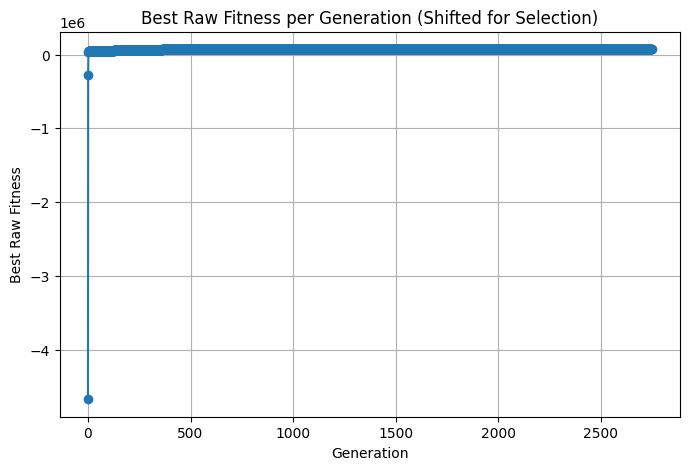

In [32]:
plot_fitness_history(fitness_history)